In [ ]:
!pip install resampy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
import librosa.display
import resampy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import specgram
import json
import glob
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [ ]:
from google.colab import files
files.upload()

Saving data.csv to data (1).csv


{'data (1).csv': b'labels,source,path\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a01.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a02.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a03.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a04.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a05.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a06.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a07.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a08.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a09.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a10.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a11.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a12.wav\r\nmale_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a13.wav\r\nmale_angry

In [ ]:
ref = pd.read_csv('/content/data.csv')
ref.head()

,labels,source,path
0,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...
1,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...
2,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...
3,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...
4,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...


# Data Preparation and Data Processing

In [ ]:
# Time-demanding snippet
df = pd.DataFrame(columns=['feature'])

# Feature extraction over the entire dataset
counter = 0
for index, path in enumerate(ref.path):
  X, sample_rate = librosa.load(path, sr=44100, offset=0.5, duration=2.5, res_type='kaiser_fast')

  sample_rate = np.array(sample_rate)

  mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  mfccs_mean = np.mean(mfccs, axis=0)

  df.loc[counter] = [mfccs_mean]
  counter += 1

print(len(df))
df.head()

12162


,feature
0,"[-4.6414194, -3.8608994, -6.21919, -5.9265423,..."
1,"[-8.690716, -12.522839, -22.928043, -23.243807..."
2,"[-8.814863, -12.819055, -24.178183, -23.84745,..."
3,"[-2.2684276, -4.317077, -12.285237, -13.083024..."
4,"[-13.485307, -16.26042, -25.884357, -27.827045..."


In [ ]:
df = pd.concat([ref, pd.DataFrame(df['feature'].values.tolist())], axis=1)
df.head()

NameError: name 'pd' is not defined

In [ ]:
df = df.fillna(0)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...,-4.641419,-3.860899,-6.219190,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088852,-5.023864,-5.254715,-5.234093,-5.310307,-5.621666,-6.072197,-6.611348,-3.999874,1.390505
1,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...,-8.690716,-12.522839,-22.928043,-23.243807,-22.926605,-23.432240,-14.830006,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496813,-22.895985,-23.511503,-24.342152,-16.465857,-8.936036
2,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...,-8.814863,-12.819055,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...,-2.268428,-4.317077,-12.285237,-13.083024,-12.041326,-11.819768,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,/content/drive/MyDrive/Project/data/SAVEE/DC_a...,-13.485307,-16.260420,-25.884357,-27.827045,-27.593534,-26.666512,-18.659025,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-20.599659,-15.929615


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, axis=1),
                                                    df.labels,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-17.142694,-17.249537,-18.365582,-18.948351,-17.365459,-16.711090,-17.699482,-18.021383,-17.897398,-15.878500,...,-22.865425,-21.614164,-19.724928,-18.845333,-19.363424,-20.137630,-22.655138,-24.578312,-24.039165,-23.209587
3860,-13.285580,-16.784794,-23.058231,-22.435650,-20.332132,-19.029636,-19.715996,-13.186263,-11.762836,-16.709417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-4.823563,-6.056048,-9.580621,-12.012060,-9.959867,-11.912548,-13.994515,-13.555813,-14.022306,-15.118245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-7.031147,-4.253551,-4.534490,-5.836689,-5.248197,-6.456452,-8.122450,-9.154640,-8.647813,-8.178625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-22.565975,-21.767017,-20.529488,-20.669310,-21.171085,-18.573400,-18.412350,-16.178040,-14.222460,-15.122540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-20.082029,-18.982424,-17.009443,-16.944057,-19.334974,-19.527683,-21.974346,-20.144060,-17.954927,-19.302568,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-20.103537,-18.625864,-16.116108,-16.929590,-18.197666,-18.149662,-19.240429,-18.361645,-16.917976,-16.639193,...,-17.848894,-19.357054,-17.748701,-19.136810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-21.078182,-18.671947,-17.676804,-18.009504,-18.218782,-18.676929,-16.592764,-17.796528,-17.992470,-17.824917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-22.707441,-20.160748,-18.926155,-19.429981,-19.278114,-18.125767,-18.068565,-19.879320,-20.896751,-19.176098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-20.008291,-17.640305,-19.188614,-18.435749,-17.538836,-17.817177,-17.898474,-20.555359,-18.578112,-15.957151,...,-18.031605,-18.101122,-19.630693,-20.707489,-20.239124,-18.337662,-15.543310,-17.478794,-17.017057,-19.112492


In [ ]:
# Normalisation
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.372310,0.351076,0.438237,0.388457,0.499096,0.543393,0.462479,0.433139,0.435822,0.580884,...,-0.878522,-0.810311,-0.690145,-0.628339,-0.673926,-0.717016,-0.859952,-0.983364,-0.969119,-0.913882
3860,0.650360,0.385364,0.090202,0.130623,0.280183,0.372213,0.313868,0.789079,0.887160,0.519767,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
9761,1.260367,1.176913,1.089782,0.901293,1.045560,0.897673,0.735525,0.761875,0.720924,0.636805,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
7620,1.101227,1.309898,1.464034,1.357870,1.393238,1.300501,1.168280,1.085870,1.116342,1.147244,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
11586,-0.018641,0.017783,0.277749,0.261218,0.218276,0.405898,0.409943,0.568838,0.706198,0.636489,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
7914,0.160420,0.223226,0.538816,0.536645,0.353764,0.335442,0.147434,0.276877,0.431590,0.329029,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
9513,0.158870,0.249532,0.605071,0.537714,0.437687,0.437182,0.348916,0.408091,0.507881,0.524932,...,-0.567516,-0.670856,-0.568431,-0.646187,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
5835,0.088610,0.246132,0.489321,0.457871,0.436129,0.398254,0.544041,0.449692,0.428828,0.437717,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
5389,-0.028839,0.136291,0.396662,0.352847,0.357960,0.438947,0.435279,0.296366,0.215151,0.338332,...,0.539051,0.525107,0.524697,0.525587,0.510751,0.511041,0.512098,0.500554,0.494117,0.487496
11222,0.165736,0.322245,0.377196,0.426356,0.486302,0.461730,0.447814,0.246599,0.385740,0.575099,...,-0.578843,-0.593259,-0.684341,-0.742362,-0.727502,-0.607248,-0.429243,-0.554730,-0.541691,-0.666502


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickling the LabelEncoder for future use
filename = '/content/drive/MyDrive/Project/labels'
with open(filename, 'wb') as outfile:
  pickle.dump(lb, outfile)

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


# Modelling

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.0, nesterov=False)
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.RMSprop(learning_rate=1e-5)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 216, 256)            │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 216, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 216, 256)            │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 216, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 216, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 216, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 27, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 27, 128)             │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 27, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 27, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 27, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 27, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 27, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 3, 64)               │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,285,390 (4.90 MB)

 Trainable params: 1,284,622 (4.90 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.1466 - loss: 2.5366 - val_accuracy: 0.2059 - val_loss: 2.4568
Epoch 2/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2564 - loss: 2.2344 - val_accuracy: 0.3022 - val_loss: 2.2482
Epoch 3/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2898 - loss: 2.1101 - val_accuracy: 0.3124 - val_loss: 2.1627
Epoch 4/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3173 - loss: 2.0227 - val_accuracy: 0.3311 - val_loss: 2.0949
Epoch 5/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3439 - loss: 1.9444 - val_accuracy: 0.3492 - val_loss: 2.0638
Epoch 6/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3529 - loss: 1.9108 - val_accuracy: 0.3571 - val_loss: 2.0097
Epoch 7/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3580 - loss: 1.8739 - val_accuracy: 0.3653 - val_loss: 1.9712
Epoch 8/100
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3719 - loss: 1.8438 - val_a

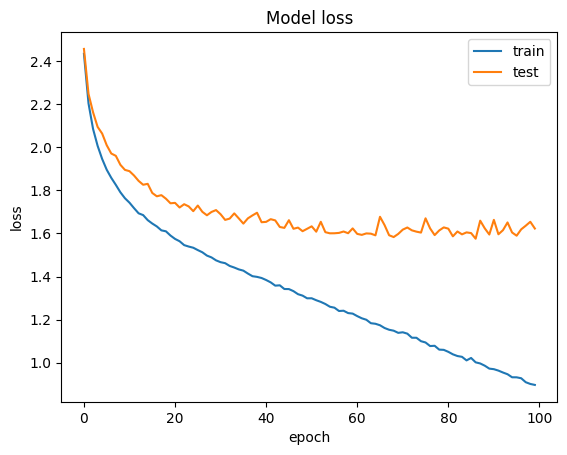

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Model Serialisation

In [ ]:
model_name_h5 = 'model.h5'
model_name_keras = 'model.keras'
model_dir = '/content/drive/MyDrive/Project/model'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

model_path_h5 = os.path.join(model_dir, model_name_h5)
model_path_keras = os.path.join(model_dir, model_name_keras)

model.save(model_path_h5)

model.save(model_path_keras)

json_file_path = os.path.join(model_dir, 'model_json.json')
model_json = model.to_json()
with open(json_file_path, 'w') as json_file:
    json_file.write(model_json)

# Model Validation

In [ ]:
with open(json_file_path, 'r') as json_file:
  loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights(model_path_keras)

# opt = keras.optimizers.rmsprop(leaning_rate=1e-5)
loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

compile_metrics: 44.20%


In [ ]:
predicted = loaded_model.predict(X_test, batch_size=16, verbose=0)
predicted = predicted.argmax(axis=1)
predicted = predicted.astype(int).flatten()
predicted = (lb.inverse_transform((predicted)))
predicted = pd.DataFrame({'predicted_values': predicted})

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actual_values': actual})

final_df = actual.join(predicted)
final_df.head(10)

,actual_values,predicted_values
0,female_disgust,female_neutral
1,female_happy,female_happy
2,male_sad,male_happy
3,male_angry,male_happy
4,male_happy,male_angry
5,male_happy,male_happy
6,male_angry,male_angry
7,female_angry,female_angry
8,male_happy,female_neutral
9,female_sad,female_sad


In [ ]:
final_df.to_csv('/content/drive/MyDrive/Project/predictions.csv', index=False)
final_df.groupby('predicted_values').count()

,actual_values
predicted_values,
female_angry,548
female_disgust,267
female_fear,176
female_happy,337
female_neutral,466
female_sad,225
female_surprise,115
male_angry,191
male_disgust,92


In [ ]:
def heat_map(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

  fig = plt.figure(figsize=figsize)
  heatmap = sns.heatmap(df_cm, annot=True, fmt='d')

  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')

0.44195988161788885


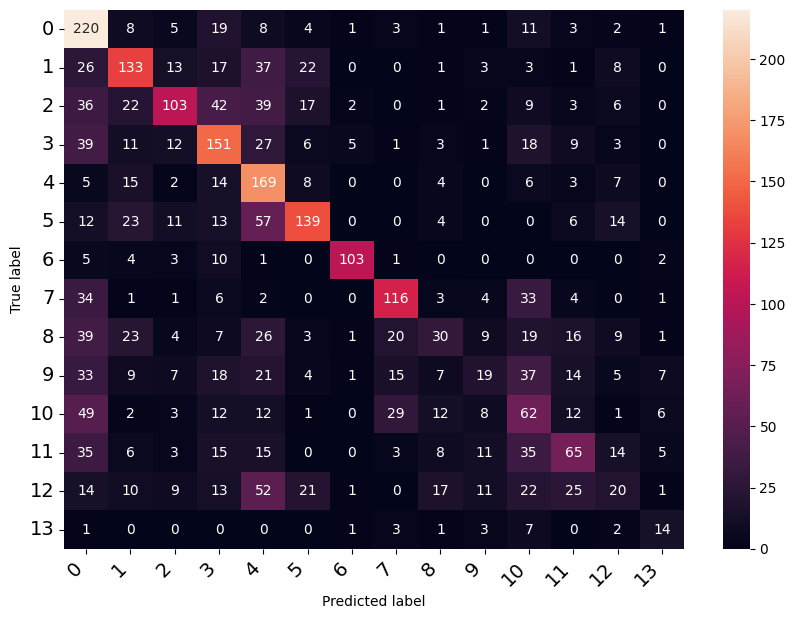

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Project/predictions.csv')
classes = final_df.actual_values.unique().sort()

cm = confusion_matrix(final_df['actual_values'], final_df['predicted_values'])
print(accuracy_score(final_df['actual_values'], final_df['predicted_values']))
heat_map(cm, class_names=classes)

In [ ]:
print(classification_report(final_df['actual_values'], final_df['predicted_values'], target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.40      0.77      0.53       287
 female_disgust       0.50      0.50      0.50       264
    female_fear       0.59      0.37      0.45       282
   female_happy       0.45      0.53      0.48       286
 female_neutral       0.36      0.73      0.48       233
     female_sad       0.62      0.50      0.55       279
female_surprise       0.90      0.80      0.84       129
     male_angry       0.61      0.57      0.59       205
   male_disgust       0.33      0.14      0.20       207
      male_fear       0.26      0.10      0.14       197
     male_happy       0.24      0.30      0.26       209
   male_neutral       0.40      0.30      0.35       215
       male_sad       0.22      0.09      0.13       216
  male_surprise       0.37      0.44      0.40        32

       accuracy                           0.44      3041
      macro avg       0.45      0.44      0.42      3041
   weighted avg       0.44   

0.7842814863531733


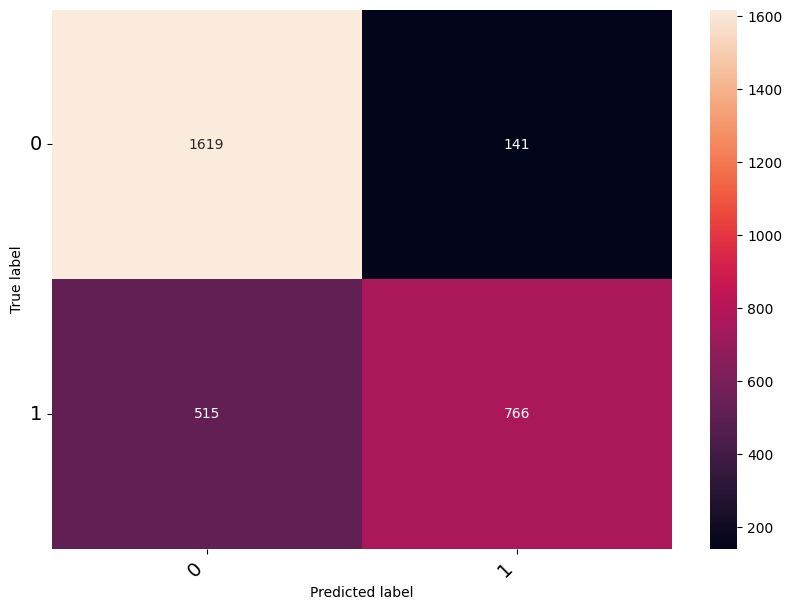

In [ ]:
sex_df = final_df.copy()  # No need for a deep copy as there are no nested elements

def replace_sex_labels(df):
    return df.replace({
        'female_angry': 'female',
        'female_disgust': 'female',
        'female_fear': 'female',
        'female_happy': 'female',
        'female_sad': 'female',
        'female_surprise': 'female',
        'female_neutral': 'female',
        'male_angry': 'male',
        'male_fear': 'male',
        'male_happy': 'male',
        'male_sad': 'male',
        'male_surprise': 'male',
        'male_neutral': 'male',
        'male_disgust': 'male'
    })

sex_df['actual_values'] = replace_sex_labels(final_df['actual_values'])
sex_df['predicted_values'] = replace_sex_labels(final_df['predicted_values'])

classes = sex_df.actual_values.unique().sort()

cm = confusion_matrix(sex_df['actual_values'], sex_df['predicted_values'])
print(accuracy_score(sex_df['actual_values'], sex_df['predicted_values']))
heat_map(cm, class_names=classes)

In [ ]:
print(classification_report(sex_df['actual_values'], sex_df['predicted_values'], target_names=classes))

              precision    recall  f1-score   support

      female       0.76      0.92      0.83      1760
        male       0.84      0.60      0.70      1281

    accuracy                           0.78      3041
   macro avg       0.80      0.76      0.77      3041
weighted avg       0.79      0.78      0.78      3041



0.49325879644853665


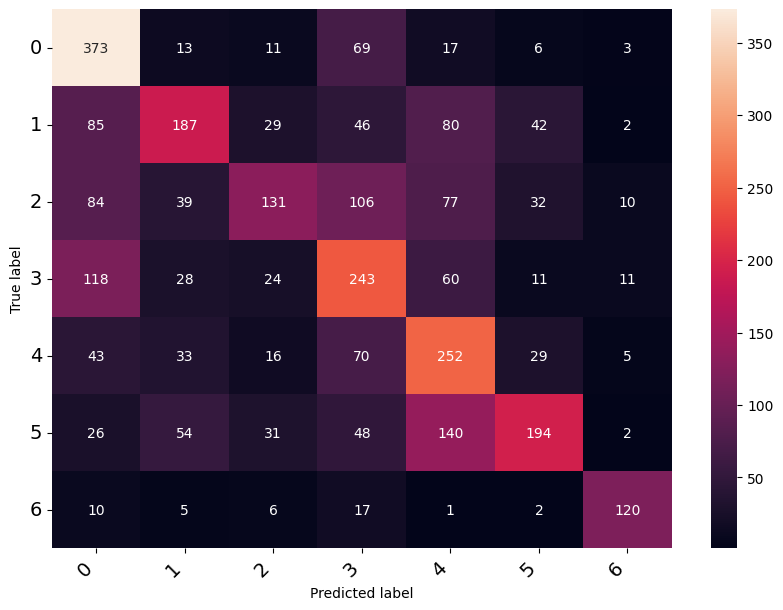

In [ ]:
emotion_df = final_df.copy()

def replace_emotion_labels(df):
  return df.replace({'female_angry': 'angry',
                     'female_disgust': 'disgust',
                     'female_fear': 'fear',
                     'female_happy': 'happy',
                     'female_sad': 'sad',
                     'female_surprise': 'surprise',
                     'female_neutral': 'neutral',
                     'male_angry': 'angry',
                     'male_fear': 'fear',
                     'male_happy': 'happy',
                     'male_sad': 'sad',
                     'male_surprise': 'surprise',
                     'male_neutral': 'neutral',
                     'male_disgust': 'disgust'})

emotion_df['actual_values'] = replace_emotion_labels(final_df['actual_values'])
emotion_df['predicted_values'] = replace_emotion_labels(final_df['predicted_values'])

classes = emotion_df['actual_values'].unique().sort()

cm = confusion_matrix(emotion_df['actual_values'], emotion_df['predicted_values'])
print(accuracy_score(emotion_df['actual_values'], emotion_df['predicted_values']))
heat_map(cm, class_names=classes)

In [ ]:
print(classification_report(emotion_df['actual_values'], emotion_df['predicted_values'], target_names=classes))

              precision    recall  f1-score   support

       angry       0.50      0.76      0.61       492
     disgust       0.52      0.40      0.45       471
        fear       0.53      0.27      0.36       479
       happy       0.41      0.49      0.44       495
     neutral       0.40      0.56      0.47       448
         sad       0.61      0.39      0.48       495
    surprise       0.78      0.75      0.76       161

    accuracy                           0.49      3041
   macro avg       0.54      0.52      0.51      3041
weighted avg       0.51      0.49      0.48      3041

